# Chinook music store

#### EDA of music store for assigning contract to musicions , finding insights about th tracks not sold 

In [1]:
import pandas as pd 
import numpy as np
import sqlite3 as sql
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
db= 'chinook.db'
def run_query(q):
    with sql.connect(db) as conn:
        return pd.read_sql_query(q,conn)

### Genreic analysis for album selection 

In [24]:
q= """

WITH usa_tracks as
    (
    select t.genre_id as genre_id, il.invoice_line_id
        from track as t
    inner join invoice_line as il on il.track_id = t.track_id
    inner join invoice as i on i.invoice_id = il.invoice_id
    where i.billing_country = 'USA'
    )
select g.name genre_name,
    count(usa.genre_id) num_purchases,
    round((cast(count(usa.genre_id)as float)/(select count(genre_id) from usa_tracks))*100,2) as percentage_sold
from usa_tracks as usa
inner join genre as g on g.genre_id = usa.genre_id

group by g.name
order by num_purchases DESC

"""
df = run_query(q)
df

,genre_name,num_purchases,percentage_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Pop,22,2.09
7,Latin,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


C:\Users\hp\AppData\Local\Temp\ipykernel_19688\4101673813.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(df['genre_name'], fontsize = 10.5, color = 'grey')


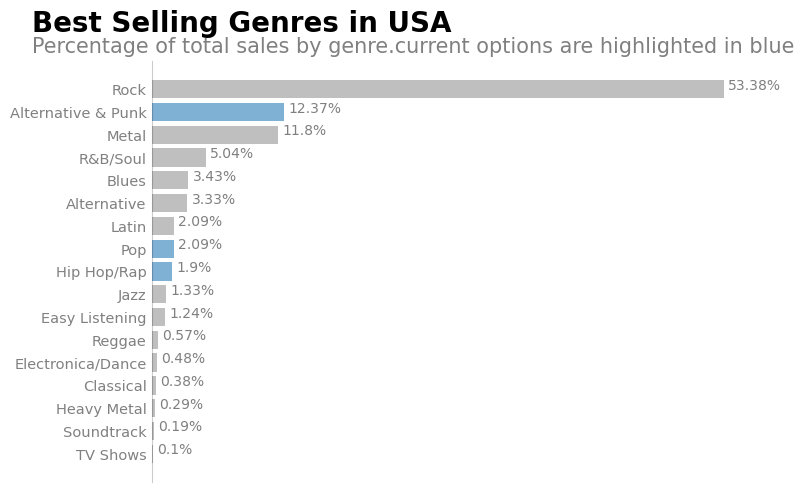

In [54]:
df = df.sort_values(by='percentage_sold')
album_options=['Hip Hop/Rap', 'Alternative & Punk','Blue', 'Pop']
cmap = df['genre_name'].apply(lambda x:'#0064AB' if x in album_options else 'grey' )
fig, ax = plt.subplots(figsize = (8,5))
bars = ax.barh(df['genre_name'], df['percentage_sold'], height = 0.8, color = cmap, alpha = 0.5)

for bar, percentage in zip(bars, df['percentage_sold']):
    ax.text(bar.get_width()+0.4, bar.get_y()+ bar.get_height()/2, f'{percentage}%' , alpha = 0.5) 

ax.set_yticklabels(df['genre_name'], fontsize = 10.5, color = 'grey')
ax.set_xticklabels([])
plt.text(-0.2,1.07, 'Best Selling Genres in USA', fontsize=20,  weight='bold' , transform= plt.gca().transAxes)
plt.text(-0.2,1.02, 'Percentage of total sales by genre.current options are highlighted in blue', fontsize=15, color = 'grey', transform= plt.gca().transAxes)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.spines['left'].set_color('#000000')
ax.spines['left'].set_alpha(0.2)

ax.tick_params(axis = 'y', which='both', length= 0)
ax.tick_params(axis = 'x', which='both', length= 0)


plt.tight_layout()
plt.show()

## EDA of music store best employee 

In [57]:
q= """

WITH t1 as
    (
    select em.first_name ||' '|| em.last_name as sales_rep_name, 
    em.hire_date,
    count(cu.customer_id) as num_invoices,
    cast(sum(iv.total) as integer) as total_sales
    from employee em
    join customer cu
    on em.employee_id= cu.support_rep_id
    join invoice iv
    on iv.customer_id = cu.customer_id
    group by 1)
select *,
        round(cast(total_sales as float)/num_invoices,2)
        as sales_per_customer
    from t1
"""
df = run_query(q)
df

,sales_rep_name,hire_date,num_invoices,total_sales,sales_per_customer
0,Jane Peacock,2017-04-01 00:00:00,212,1731,8.17
1,Margaret Park,2017-05-03 00:00:00,214,1584,7.40
2,Steve Johnson,2017-10-17 00:00:00,188,1393,7.41


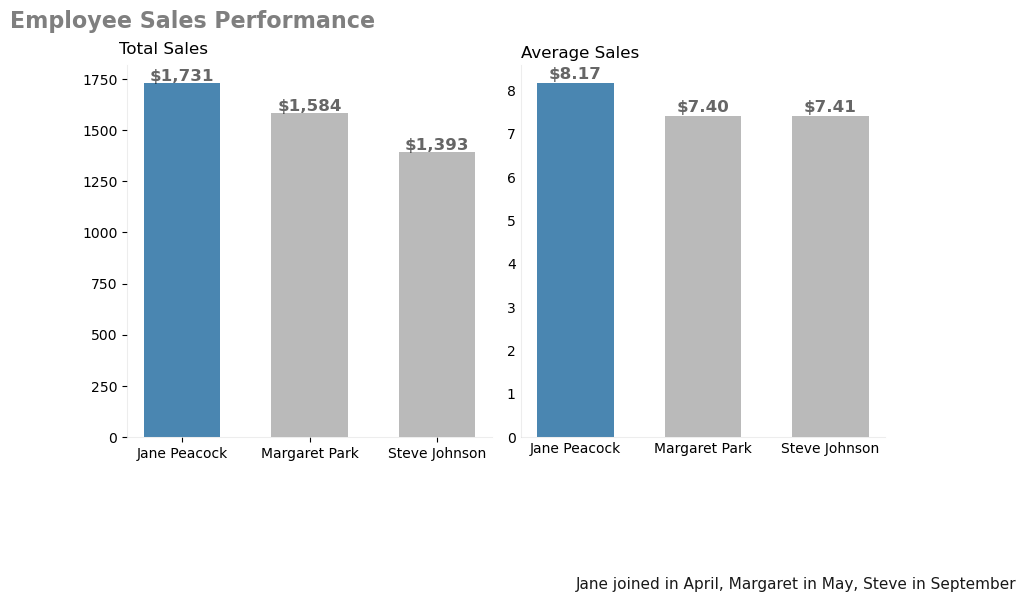

In [99]:

sales_rep_name = df['sales_rep_name'].values
total_sales = df['total_sales'].values
sales_per_customer = df['sales_per_customer'].values

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,8))

axes[0].bar(sales_rep_name, total_sales, color = '#bababa',width = 0.6)
axes[0].bar(sales_rep_name[0], total_sales[0], color = '#0064AB',alpha = 0.6,width = 0.6)

axes[0].text(x=-1.1,y= 1.03 , s='Total Sales', size=12 , transform= plt.gca().transAxes)

for sales, index in zip(total_sales, range(3)):
    axes[0].text(x=index, y=sales+10,s= '${:,}'.format(sales), 
    ha='center', fontweight='bold',  alpha = 0.6, size=12) 
    
axes[0].text(x=-1.4,y= 1.1 , s='Employee Sales Performance', size=16,  fontweight='bold',alpha=0.5 , transform= plt.gca().transAxes)

axes[1].bar(sales_rep_name, sales_per_customer, color = '#bababa',width = 0.6)
axes[1].bar(sales_rep_name[0], sales_per_customer[0], color = '#0064AB',alpha = 0.6,width = 0.6)

axes[1].text(x=0,y= 1.02 , s='Average Sales', size=12 , transform= plt.gca().transAxes)

for sales, index in zip(sales_per_customer, range(3)):
    axes[1].text(x=index, y=sales+.10,s= '${:,.2f}'.format(sales), 
    ha='center', fontweight='bold',  alpha = 0.6, size=12) 

axes[1].text(x=0,y= -3.5 , s='Jane joined in April, Margaret in May, Steve in September',
             size=11,alpha=0.9)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDD')
    ax.spines['left'].set_alpha(0.5)
    ax.spines['bottom'].set_color('#DDD')
    ax.spines['bottom'].set_alpha(0.5)


ax.tick_params(axis = 'y', which='both', length= 0)
ax.tick_params(axis = 'x', which='both', length= 0)
   


plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

## EDA of music store for finding new target markets 

In [128]:
q = """
    -- calculate the number of customers in each country
    with t1 as ( 
        select country, count(customer_id) as num_customers
        from customer
        group by country
    ),
    
    -- calculate the total sales in each country 
    t2 as (
        select cu.country,
            round(sum(iv.total),2) as total_sales,
            count(iv.invoice_id) as num_sales
        from customer cu
        join invoice iv on cu.customer_id = iv.customer_id
        group by cu.country
    ),
    
    -- group countries with only one customer as 'others'
    t3 as (
        select 
            case when t1.num_customers = 1 then 'others'
                 else t1.country 
            end as countries,
            sum(t1.num_customers) as num_customers,
            sum(t2.total_sales) as total_sales,
            sum(t2.num_sales) as num_sales
        from t1
        join t2 on t1.country = t2.country
        group by 1
    )
    
    -- calculate relevant sales metrics
    select  
        countries,
        num_customers,
        total_sales,
        round(total_sales/num_sales,2) as avg_order_value,
        round(total_sales/num_customers,2) as sales_per_customer
    from (
        select *,
            case when countries = 'Others' then 1
                 else 0 
            end as sort
        from t3
    ) as subquery
    order by sort, num_customers DESC;
"""

df = run_query(q)
df


,countries,num_customers,total_sales,avg_order_value,sales_per_customer
0,others,15,1094.94,7.45,73.00
1,USA,13,1040.49,7.94,80.04
2,Canada,8,535.59,7.05,66.95
3,Brazil,5,427.68,7.01,85.54
4,France,5,389.07,7.78,77.81
5,Germany,4,334.62,8.16,83.66
6,United Kingdom,3,245.52,8.77,81.84
7,Czech Republic,2,273.24,9.11,136.62
8,India,2,183.15,8.72,91.58
9,Portugal,2,185.13,6.38,92.57


In [129]:
avg_cust_purchase = df.sales_per_customer.mean()
print(avg_cust_purchase)
df['pcent_customer'] = round(100*df.num_customers / df.num_customers.sum(),1)
df['pcent_sales'] = round(100*df.total_sales / df.total_sales.sum(),1)
df['cust_purchase_diff'] = round(100*(df.sales_per_customer-
                        avg_cust_purchase)/ avg_cust_purchase,2)


86.96100000000001


In [131]:
df

,countries,num_customers,total_sales,avg_order_value,sales_per_customer,pcent_customer,pcent_sales,cust_purchase_diff
0,others,15,1094.94,7.45,73.00,25.4,23.2,-16.05
1,USA,13,1040.49,7.94,80.04,22.0,22.1,-7.96
2,Canada,8,535.59,7.05,66.95,13.6,11.4,-23.01
3,Brazil,5,427.68,7.01,85.54,8.5,9.1,-1.63
4,France,5,389.07,7.78,77.81,8.5,8.3,-10.52
5,Germany,4,334.62,8.16,83.66,6.8,7.1,-3.80
6,United Kingdom,3,245.52,8.77,81.84,5.1,5.2,-5.89
7,Czech Republic,2,273.24,9.11,136.62,3.4,5.8,57.10
8,India,2,183.15,8.72,91.58,3.4,3.9,5.31
9,Portugal,2,185.13,6.38,92.57,3.4,3.9,6.45


In [120]:
(136.62-86.96)

49.66000000000001

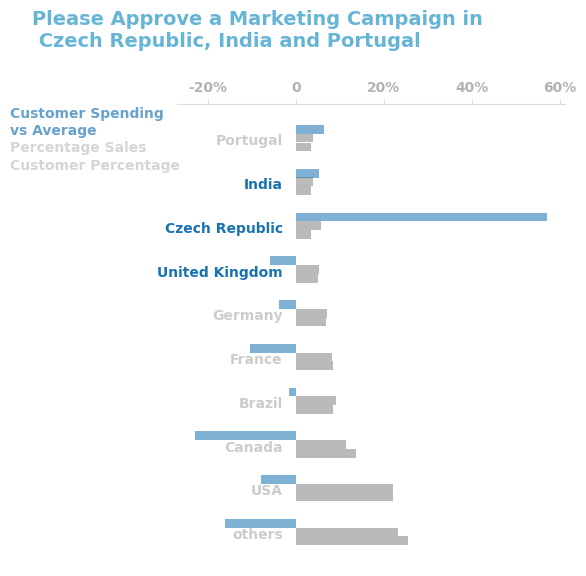

In [181]:
y_labs = df.countries.values
y_axes = np.arange(df.countries.size)

fig = plt.figure(figsize =(5,6))
plt.barh(y_axes-0.3, df.pcent_customer, height = 0.2, color= '#bababa')
plt.barh(y_axes-0.1, df.pcent_sales, height = 0.2, color= '#bababa')
plt.barh(y_axes+0.1, df.cust_purchase_diff, height = 0.2, color= '#0064AB', alpha=0.5)

color_map = ['','','','','','','yes','yes','yes','']

for loc, label, color in zip(y_axes, y_labs, color_map):
    if color == 'yes':
        plt.text(x=-3, y=loc-0.25, s=label, ha='right', color='#0064AB', alpha=0.9, size=10, fontweight='bold')
    else:
        plt.text(x=-3, y=loc-0.25, s=label, ha='right', size=10, color='grey', alpha=0.4, fontweight='bold')

plt.text(x=-65,y=9,s='Customer Spending \nvs Average', color='#0064AB',size=10, alpha = 0.6, fontweight = 'bold')
plt.text(x=-65,y=8.6,s='Percentage Sales', color='#BABABA',size=10, alpha = 0.6, fontweight = 'bold')
plt.text(x=-65,y=8.2,s='Customer Percentage', color='#BABABA',size=10, alpha = 0.6, fontweight = 'bold')

plt.text(x=-60,y=11,s='Please Approve a Marketing Campaign in\n Czech Republic, India and Portugal ', color='#0085BB',size=14, alpha = 0.6, fontweight = 'bold')

for ax in fig.get_axes():
    plt.sca(ax)
    sns.despine(left=True, bottom = True, top=False)
    ax.tick_params(left=False, bottom=False, color='#ddd')
    ax.xaxis.set_ticks_position('top')
    ax.spines['top'].set_color('#ddd')
    plt.yticks([])
    plt.xticks([-20,0,20,40,60],['-20%','0','20%','40%','60%'], size=10, alpha=0.3, fontweight='bold')

plt.show()

## EDA of music store for finding unsold tracks

In [187]:
q = """
with all_and_purchased as 
( 
    select t.track_id as all_tracks, il.track_id as purchased_tracks
    from track as t
    left join invoice_line il on il.track_id = t.track_id
)

select 
    count(distinct a.all_tracks) as total_tracks,
    count(distinct a.purchased_tracks) as tracks_purchased,
    count(distinct a.all_tracks) - count(distinct a.purchased_tracks) as not_purchased,
    round(count(distinct a.purchased_tracks) / cast(count(distinct a.all_tracks) as float), 2) as percentage_purchase
from all_and_purchased as a;
"""

df = run_query(q)
df


,total_tracks,tracks_purchased,not_purchased,percentage_purchase
0,3503,1806,1697,0.52


In [190]:
df = df.T
df = df.iloc[[1,2],0]
purchased_list= df.tolist()

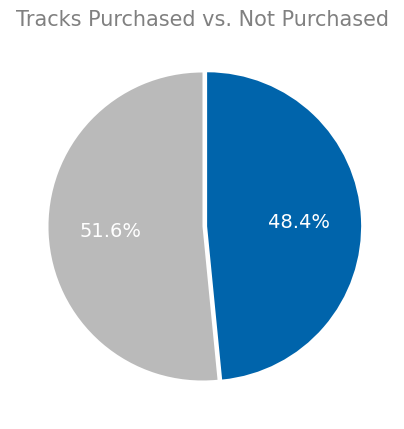

In [192]:
plt.pie(purchased_list,
        explode=(0, 0.03),
        startangle=90, 
        autopct='%1.1f%%',
        textprops={'fontsize': 14, 'color': 'white'},
        colors=('#BABABA', '#0064AB'))
plt.title('Tracks Purchased vs. Not Purchased', fontsize=15, color="gray")
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.show()


In [195]:
q = """
select ar.name as artist_name,
        g.name as genre,
        count(il.track_id) as units_sold
from track t
left join invoice_line il on il.track_id = t.track_id
inner join album al on al.album_id = t.album_id
inner join artist ar on ar.artist_id = al.artist_id
inner join genre as g on g.genre_id = t.genre_id
group by artist_name
having units_sold = 0
order by units_sold;
"""

run_query(q)


,artist_name,genre,units_sold
0,Aaron Copland & London Symphony Orchestra,Classical,0
1,Academy of St. Martin in the Fields Chamber En...,Classical,0
2,"Academy of St. Martin in the Fields, John Birc...",Classical,0
3,"Academy of St. Martin in the Fields, Sir Nevil...",Classical,0
4,Adrian Leaper & Doreen de Feis,Classical,0
...,...,...,...
69,The Office,TV Shows,0
70,The Tea Party,Alternative & Punk,0
71,Ton Koopman,Classical,0
72,Toquinho & Vinícius,Bossa Nova,0


In [200]:
q= """
WITH invoice_data AS 
( 
    SELECT invoice_id, MIN(track_id) AS track_id
    FROM invoice_line
    GROUP BY 1 
),
album_purchased AS 
(
    SELECT 
        invoice_id,
        CASE
            WHEN (
                SELECT t2.track_id
                FROM track t1
                JOIN track t2 ON t1.album_id = t2.album_id
                WHERE t1.track_id = invoice_data.track_id
                
                EXCEPT
                
                SELECT il.track_id
                FROM invoice_line il
                WHERE il.invoice_id = invoice_data.invoice_id
            ) IS NULL
            AND (
                SELECT il.track_id
                FROM invoice_line il
                WHERE il.invoice_id = invoice_data.invoice_id
                
                EXCEPT
                
                SELECT t2.track_id
                FROM track t1
                JOIN track t2 ON t1.album_id = t2.album_id
                WHERE t1.track_id = invoice_data.track_id
            ) IS NULL
            THEN 'yes'
            ELSE 'no'
        END AS purchased_album
    FROM invoice_data
)

SELECT 
    purchased_album,
    COUNT(invoice_id) AS no_of_invoices,
    CAST(COUNT(invoice_id) AS float) * 100 / (SELECT COUNT(*) FROM album_purchased) AS purchased_percentage
FROM album_purchased
GROUP BY 1;
"""
run_query(q)

,purchased_album,no_of_invoices,purchased_percentage
0,no,500,81.433225
1,yes,114,18.566775
